# First NN to test a simple model

In this notebook, we implement a simple neural network to predict the photovoltaic power generation. We use the data from the University of Liege.

### import libraries

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader

In [3]:
DATA_PATH = 'data/cleaned.csv'

In [4]:
df = pd.read_csv('data/cleaned.csv', sep=';',  parse_dates=[0])
df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df

,date,id,Power_1,Power_2,Power_3,Power_4,Power_5,Power_6,Power_7,Power_8,...,CU,CM,CD,TT2M,ST,RH2m,WS10m,WS100m,PREC,SNOW
0,2022-01-01 02:15:00+02:00,577035.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,8.38,8.38,93.34,3.46,9.10,0.0,0.0
1,2022-01-01 02:30:00+02:00,577038.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,8.52,8.52,92.18,3.81,9.52,0.0,0.0
2,2022-01-01 02:45:00+02:00,577041.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,8.66,8.66,90.91,4.15,9.66,0.0,0.0
3,2022-01-01 03:00:00+02:00,577044.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,8.76,8.76,90.18,4.36,9.50,0.0,0.0
4,2022-01-01 03:15:00+02:00,577047.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,8.74,8.74,90.39,4.38,9.16,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28845,2022-12-31 21:30:00+02:00,667201.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.76,0.0,0.0,13.14,13.14,72.48,7.39,13.79,0.0,0.0
28846,2022-12-31 21:45:00+02:00,667204.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00,0.0,0.0,13.13,13.13,72.07,7.46,13.93,0.0,0.0
28847,2022-12-31 22:00:00+02:00,667207.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00,0.0,0.0,13.12,13.12,71.67,7.52,14.04,0.0,0.0
28848,2022-12-31 22:15:00+02:00,667210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00,0.0,0.0,13.10,13.10,71.36,7.55,14.10,0.0,0.0


In [5]:
col_to_keep = ['Power_Total','date' ,'SWD', 'SWDtop', 'CU', 'CM', 'CD', 'TT2M', 'ST', 'RH2m', 'WS10m', 'WS100m', 'PREC', 'SNOW']
df = df.loc[:,col_to_keep]
df.dropna(inplace=True)
df.head()

,Power_Total,date,SWD,SWDtop,CU,CM,CD,TT2M,ST,RH2m,WS10m,WS100m,PREC,SNOW
0,0.0,2022-01-01 02:15:00+02:00,0.0,0.0,0.0,0.0,0.0,8.38,8.38,93.34,3.46,9.10,0.0,0.0
1,0.0,2022-01-01 02:30:00+02:00,0.0,0.0,0.0,0.0,0.0,8.52,8.52,92.18,3.81,9.52,0.0,0.0
2,0.0,2022-01-01 02:45:00+02:00,0.0,0.0,0.0,0.0,0.0,8.66,8.66,90.91,4.15,9.66,0.0,0.0
3,0.0,2022-01-01 03:00:00+02:00,0.0,0.0,0.0,0.0,0.0,8.76,8.76,90.18,4.36,9.50,0.0,0.0
4,0.0,2022-01-01 03:15:00+02:00,0.0,0.0,0.0,0.0,0.0,8.74,8.74,90.39,4.38,9.16,0.0,0.0


In [6]:
#split the column date into month, day, hour, minutes
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df['hour'] = df['date'].apply(lambda x: x.hour)
df['minutes'] = df['date'].apply(lambda x: x.minute)
df.drop(columns=['date'], inplace=True)
df.head()

,Power_Total,SWD,SWDtop,CU,CM,CD,TT2M,ST,RH2m,WS10m,WS100m,PREC,SNOW,month,day,hour,minutes
0,0.0,0.0,0.0,0.0,0.0,0.0,8.38,8.38,93.34,3.46,9.10,0.0,0.0,1,1,2,15
1,0.0,0.0,0.0,0.0,0.0,0.0,8.52,8.52,92.18,3.81,9.52,0.0,0.0,1,1,2,30
2,0.0,0.0,0.0,0.0,0.0,0.0,8.66,8.66,90.91,4.15,9.66,0.0,0.0,1,1,2,45
3,0.0,0.0,0.0,0.0,0.0,0.0,8.76,8.76,90.18,4.36,9.50,0.0,0.0,1,1,3,0
4,0.0,0.0,0.0,0.0,0.0,0.0,8.74,8.74,90.39,4.38,9.16,0.0,0.0,1,1,3,15


In [7]:
class TriplePs(Dataset):
    def __init__(self, data, test = False, test_size = 0.2, seed=42):
        self.data = data
        self.nb_input = len (data.columns) - 1
        self.input = data.iloc[:, 1:]
        self.output = data.iloc[:, 0]
        self.test = test
        self.train_size = 1-test_size

        self.seed = seed
        np.random.seed(seed)

        self.idx = np.arange(len(data))
        np.random.shuffle(self.idx)
        self.train_idx = self.idx[:int(len(self.idx)*self.train_size)]
        self.test_idx = self.idx[int(len(self.idx)*self.train_size):]

        #convert to tensor
        self.input = torch.tensor(self.input.values, dtype=torch.float32)
        self.output = torch.tensor(self.output.values, dtype=torch.float32)

        if self.test:
            self.input = self.input[self.test_idx]
            self.output = self.output[self.test_idx]
        else:
            self.input = self.input[self.train_idx]
            self.output = self.output[self.train_idx]


    def __len__(self):
        return len(self.input)
    
    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]
    


In [8]:
trainset = TriplePs(df)
testset = TriplePs(df, test=True)

In [9]:
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [10]:
next(iter(trainloader))

[tensor([[1.0201e+02, 3.5691e+02, 0.0000e+00, 0.0000e+00, 6.7000e-01, 1.4740e+01,
          1.4740e+01, 7.0650e+01, 2.0700e+00, 3.5700e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+01, 6.0000e+00, 1.8000e+01, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 2.6000e-01, 1.0000e-02, 0.0000e+00, 1.9940e+01,
          1.9940e+01, 8.1840e+01, 2.4400e+00, 5.7600e+00, 0.0000e+00, 0.0000e+00,
          6.0000e+00, 4.0000e+00, 2.2000e+01, 3.0000e+01],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 4.4000e-01,
          4.4000e-01, 1.0000e+02, 7.5000e-01, 2.1900e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00, 1.3000e+01, 2.1000e+01, 1.5000e+01],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.2570e+01,
          1.2570e+01, 9.3320e+01, 3.0600e+00, 5.5800e+00, 0.0000e+00, 0.0000e+00,
          5.0000e+00, 1.2000e+01, 5.0000e+00, 3.0000e+01]]),
 tensor([25316.,     0.,     0.,     0.])]

### Neural Network to predict the photovoltaic power generation using simple regression

In [26]:
class Net(nn.Module):
    def __init__(self, len):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(len, 6)
        self.fc2 = nn.Linear(6, 12)
        self.fc3 = nn.Linear(12, 1)

        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [27]:
net = Net(len(trainset.input[0]))
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
nb_epoch = 30
losses = []


In [28]:
for epoch in range(nb_epoch):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = torch.tensor(inputs, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.float32)
        
        optimizer.zero_grad()
        outputs = net(inputs).clone().detach()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 2000}')
            losses.append(running_loss)
            running_loss = 0.0


/tmp/ipykernel_96042/4185963409.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
/tmp/ipykernel_96042/4185963409.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)
/home/lambi/miniconda3/envs/MLOps/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1, 2000] loss: 10992680691.828558
[1, 4000] loss: 9906993888.128
[2, 2000] loss: 9330697654.368
[2, 4000] loss: 9479552237.6
[3, 2000] loss: 9317617902.784
[3, 4000] loss: 9262807591.872
[4, 2000] loss: 9696348552.48
[4, 4000] loss: 9058075111.456
[5, 2000] loss: 9033954907.744
[5, 4000] loss: 9430267012.576
[6, 2000] loss: 9582498802.912
[6, 4000] loss: 9181518083.84
[7, 2000] loss: 9179450394.272
[7, 4000] loss: 9372129715.808
[8, 2000] loss: 9144315172.32
[8, 4000] loss: 9501165389.408
[9, 2000] loss: 9148111940.224
[9, 4000] loss: 9397221875.808
[10, 2000] loss: 9212566052.64
[10, 4000] loss: 9778804252.864
[11, 2000] loss: 9393675154.384
[11, 4000] loss: 9362115002.528
[12, 2000] loss: 9086990975.744
[12, 4000] loss: 9489535048.928
[13, 2000] loss: 9235574995.456
[13, 4000] loss: 9275642381.504
[14, 2000] loss: 9194021564.304
[14, 4000] loss: 9445900554.944
[15, 2000] loss: 9494257021.344
[15, 4000] loss: 9469639152.64
[16, 2000] loss: 9104787205.92
[16, 4000] loss: 9518152080.32

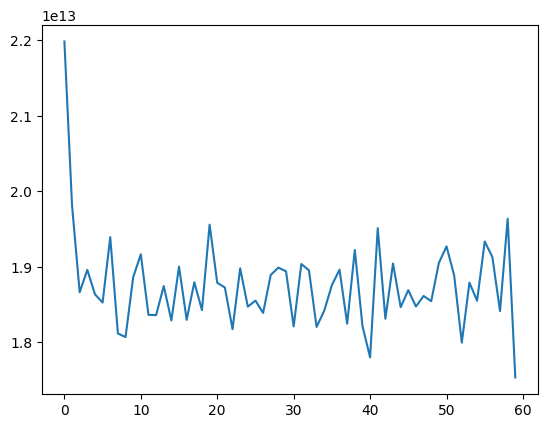

In [29]:
# plot the losses
plt.plot(losses)
plt.show()

### Neural Network to predict the photovoltaic power generation with a normal distribution

In [22]:
class Net_Normal(nn.Module):
    def __init__(self, len):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(len, 6)
        self.fc2 = nn.Linear(6, 12)
        self.fc3 = nn.Linear(12, 2)

# i want to predict a normal so i need reparametrization trick
    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        mu, logvar = torch.chunk(x, 2, dim=1)
        return self.reparametrize(mu, logvar), mu, logvar
    

In [23]:
net = Net_Normal(len(trainset.input[0]))
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
nb_epoch = 30
losses = []


In [24]:
for epoch in range(nb_epoch):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = torch.tensor(inputs, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.float32)
        
        optimizer.zero_grad()
        outputs, mu, logvar = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 2000}')
            losses.append(running_loss)
            running_loss = 0.0


/tmp/ipykernel_96042/2892581068.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
/tmp/ipykernel_96042/2892581068.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)
/home/lambi/miniconda3/envs/MLOps/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1, 2000] loss: 13297975791.728298
[1, 4000] loss: 9685135440.992
[2, 2000] loss: 9901127026.208
[2, 4000] loss: 9228975742.912
[3, 2000] loss: 9020075918.592
[3, 4000] loss: 9469386632.0
[4, 2000] loss: 9194476634.496
[4, 4000] loss: 9475455369.216
[5, 2000] loss: 9336519367.632
[5, 4000] loss: 9391633471.968
[6, 2000] loss: 9163776935.904
[6, 4000] loss: 9647887873.024
[7, 2000] loss: 9647185357.376
[7, 4000] loss: 9314558924.48
[8, 2000] loss: 9740771145.36
[8, 4000] loss: 9097205867.36
[9, 2000] loss: 9568243694.096
[9, 4000] loss: 9103192898.912
[10, 2000] loss: 9480598084.176
[10, 4000] loss: 9293102050.528
[11, 2000] loss: 9435827088.256
[11, 4000] loss: 9196691576.416
[12, 2000] loss: 9505186969.056
[12, 4000] loss: 9250287286.592
[13, 2000] loss: 9324041982.528
[13, 4000] loss: 9329902648.192
[14, 2000] loss: 9381988731.552
[14, 4000] loss: 9447036448.176
[15, 2000] loss: 9343183043.712
[15, 4000] loss: 9361688575.808
[16, 2000] loss: 9259111893.36
[16, 4000] loss: 9530513259.